Load Packages

In [1]:
library(tsModel); library(splines); library(data.table); library(lmtest); library(mgcv); library(readxl); library(ggplot2); library(MuMIn); library(dplyr);

Time Series Modeling for Air Pollution and Health (0.6-2)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:data.table':

    yearmon, yearqtr


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: nlme

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Load city's dataset and perform some preprocessing

In [2]:
# Load and inspect the dataset.
data <- read.csv("Amman.csv")
# convert data into Rdata table
data <- as.data.table(data)
data$date <- as.Date(data$Date)
data$trend <- as.numeric(data$date)
data$year <- year(data$date)
data$dow <- weekdays(data$date)
data$temp <- data$t2m
# Number of years
nyears=length(unique(data$year))

# Sort data by date
data <- data[order(data$date),]

names(data)
head(data)

[1] "Date"             "Total..30"        "Total_Male..30"   "Total_Female..30"
 [5] "X.65"             "X.65_Male"        "X.65_Female"      "Premature"       
 [9] "Premature_Male"   "Premature_Female" "YLL"              "YLL_Male"        
[13] "YLL_Female"       "Total"            "Total_Male"       "Total_Female"    
[17] "Holiday"          "PM10"             "NO2"              "SO2"             
[21] "t2m"              "sp"               "d2m"              "RH"              
[25] "Holiday.1"        "date"             "trend"            "year"            
[29] "dow"              "temp"

Date,Total..30,Total_Male..30,Total_Female..30,X.65,X.65_Male,X.65_Female,Premature,Premature_Male,Premature_Female,⋯,t2m,sp,d2m,RH,Holiday.1,date,trend,year,dow,temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<date>,<dbl>,<int>,<chr>,<dbl>
2015-01-01,18,10,8,12,7,5,12,5,7,⋯,11.45,93.7898,3.50,58.11,1,2015-01-01,16436,2015,Thursday,11.45
2015-01-02,17,12,5,12,8,4,11,8,3,⋯,8.66,94.0537,5.03,77.96,0,2015-01-02,16437,2015,Friday,8.66
2015-01-03,19,9,10,12,6,6,15,6,9,⋯,8.00,93.8048,5.05,81.64,1,2015-01-03,16438,2015,Saturday,8.00
2015-01-04,12,8,4,10,7,3,7,4,3,⋯,8.01,93.7163,5.52,84.29,0,2015-01-04,16439,2015,Sunday,8.01
2015-01-05,25,14,11,19,10,9,12,8,4,⋯,9.40,93.4567,3.13,64.91,0,2015-01-05,16440,2015,Monday,9.40
2015-01-06,25,18,7,20,14,6,10,8,2,⋯,8.51,93.1210,0.01,55.13,0,2015-01-06,16441,2015,Tuesday,8.51


Specify the target variable (y)

In [3]:
data$y <- data$Total..30
data$y

[1] 18 17 19 12 25 25 18 19 15 27 22 17 26 21 27 27 18 20 21 16 22 10 27 20
  [25] 15 18 16 23 19 11 14 11 20 21 18 17 17 18 13 21 27 15 12 17 10 14 13 16
  [49] 10 29 18 14 17 16 19 18 19 14 16 20 13  9 20 12 16 26 26 20 21 16 14 18
  [73] 13 16 13 17 19 14 16 12 17 12  9 21 18 14 18 17 11 18 10 14 21 11 20 19
  [97] 19 17 17 16 15 22 11 22 22 11 16 22 13 13 23 15 22 19 12 21 13 11 14 22
 [121] 12 17 13 16 12 12 12  9 13 17 24  9  6 17 12 12 19 13 17 21 22 11  7 18
 [145] 13 13 15 18 11 18 15 15 14  9 10  8 18 11  9 11 12  5 14 19  9 10  8 14
 [169] 15 14 13 11  9 15 15 17 13  5 11 12  9 10 20 15  8 16 16 10 15  9 15 13
 [193] 12 12 11 17 11 16 14 16 10 12 25 14 12 15 18  8 21 20 22 12 19 15 27 16
 [217] 18 19 20 11 23 17 18 11  8  9 13 18  9  8 16 14 15 10  9  9 19 12 14 11
 [241] 16 13 10  9 14 16 10 10 13 11 16 25 22 12 15 15 13 10 17 23 18 15 16 10
 [265] 14 12 19 12 10 11 11 13 16 14 13 12 10 12 12 21  9 11  8 15 12 18 22 15
 [289] 21  8 15 10  7 13 13 10 23 11 12 15 15 14 13 11 16 12 17  9 11 21 19 19
 [313] 22 14 17 14 21 18 12 12 10 19 17 12 18 15 13  9 15 14 14 21 13 15 13 13
 [337] 16 18 21 15 16 18 17 19 17 21 20 13 14 24 17 15 17 20 18 13 17  8 18 14
 [361] 17 21 16 21 23 25 23 29 22 25 19 23 17 29 19 20 17 34 18 20 20 26 16 17
 [385] 18 16 20 22 21 25 19 14 13 26 15 21 17 16 16 15 25 23 22 19 10 15 15 19
 [409] 16 22 16 14 14 19 12 16 16 15 16 17 20 11 16 16 10 14 21 21 19 12 16 13
 [433] 17 14 24 18 18 20 25 15 16 13 19 21 13 12 17  9 16 22 15 12 20  6 14 14
 [457] 21 15 14 15 10 17 26 23 19 14 13  7 17 19 19  9 12 19 18 17 15 18 20 16
 [481] 12 18 13 18 10 12 14 14 21 23  5 19 11 17 10 14 10 16 15 15 14 26 12 12
 [505] 19  9 21 12 15 17 13 14 10 12 11 14 17 17 14 17 12 20 16  8 20 13  9 12
 [529] 10 24 15 10 14 17 20  9 15 15 20 14 13 16 18 14 12 14 21 11 14 12 14 16
 [553] 10 19 14 15 13 20 16 21 10 12 14 14 10 18 11 15 18 13 15 17 19 18 17  8
 [577] 12  8 16 16 13 14  9  7 13 10 18 16  6 13 10 12  9 10 14 12 19 18 17 18
 [601] 10 13 13  8 11 11 14 15 12 10  5  9 12 19  8 13 11 14 19 17 11 13 16 12
 [625]  8 14 12 10  9 13 13 15 11  7 14 16 13  9 15 13 12 15 11 13 14 15 14 14
 [649] 15 18 10 15 16 15 10 19 14 10 13 11  8 12 16  9 15 16 10 14 12 13  8  6
 [673] 21 12 22 12 15 12 18 14 13 10 20 18 20 16 13 11 18 17 14 15 12 20 19 20
 [697] 29 15 17 23 13 13 26 16 14 23 29 24 22 15 20 10 23 20 23 17 26 26 24 26
 [721] 19 26 23 24 17 15 27 17 23 17 16 21 21 18 20 18 16 29 20 15 14 17 17 17
 [745] 15 11 17 21 15 21 26 17 16 27 16 14 20 16 17 22 20 20 20 20 18 13 23 20
 [769] 19 10 22 20 26 19 14 15 13 15 18 28 20 11 26 19 23 17 15 19 11 13 17 16
 [793] 16 15 15 17 15 15 13 21 17 10 16 15 13 21 19  8  9 24 17 21 14 18 12 18
 [817] 21 12 14 22 15 13 10 19 17 13 12 24 16 19 20 10 10 17 13 14 20 19 12 14
 [841] 13 13 13 13 20 14 15 13 13 17 13 14  9 20 12 13  9 11 14 14 12 13 17 18
 [865] 10 16 13 10 22  6 13 15 15 17  9 15 14 14 12 11 14  8 18  8 19 20  9 18
 [889] 18 27 10 16 17 15 14  9 19 13 11 25 12 13 11  9 20 11 20 12 12 21 15 14
 [913] 20 17 13 14 25  8 18 17 18 12 14 18 17 14 20 17 18 13 11 15 24 18 14 11
 [937] 14 14 16  9 14  4 15 19 15 17 14 13 21 16  8 17 13 14 18 12 12 10 11 13
 [961] 14 13 19 11 11  5 11 18 16 17 19 13 11 15 18 10 12 16 13 12 18 23 21 17
 [985]  9 17 14 22 15  9 13 16 16 16 18 10 17 11  9 11 13 13 11  9  9 13 13 17
[1009] 18 13 16 21 23 20 14 19 14 22 16 17 12  8 16 21 12 11 16 13 14 17 17 16
[1033] 11 15 12 13 14 15 12 14 16 13 20 14 24 10 17 16 17 18 17 10 15 19  8 15
[1057] 16 14 21 14 10 16 19 14 20 20 16 17 14 24 18 21 22 19 13 18 13 17 11 26
[1081] 22 15 13 16 20 18 21 15 14 21 17 22 21 16 15 19 19 25 20 12 11 19 26 21
[1105] 18 19 13 16 17 23 12 21 15 21 13 16 22 21 19 16 11  9 15 11 22 15 20 15
[1129] 17 25 10 18 14 17 17 17 21 20 21 17 16 15 20 15 23  9 15 15 15 11 19 19
[1153] 18 12 20 14 24 19 26 15 22 20 21 20 18 15 13 12 19 16 16 15 19 21 24 16
[1177] 23 14 18 17 10 16 18 16 11 15 16 14 17 11 22 13 16 21 19 10 13 13 16 20
[1201] 17 17 18 13 18 18 14 12 12 11 19 14 14 12 14 1

Time series plotting

Visualize target variable overtime

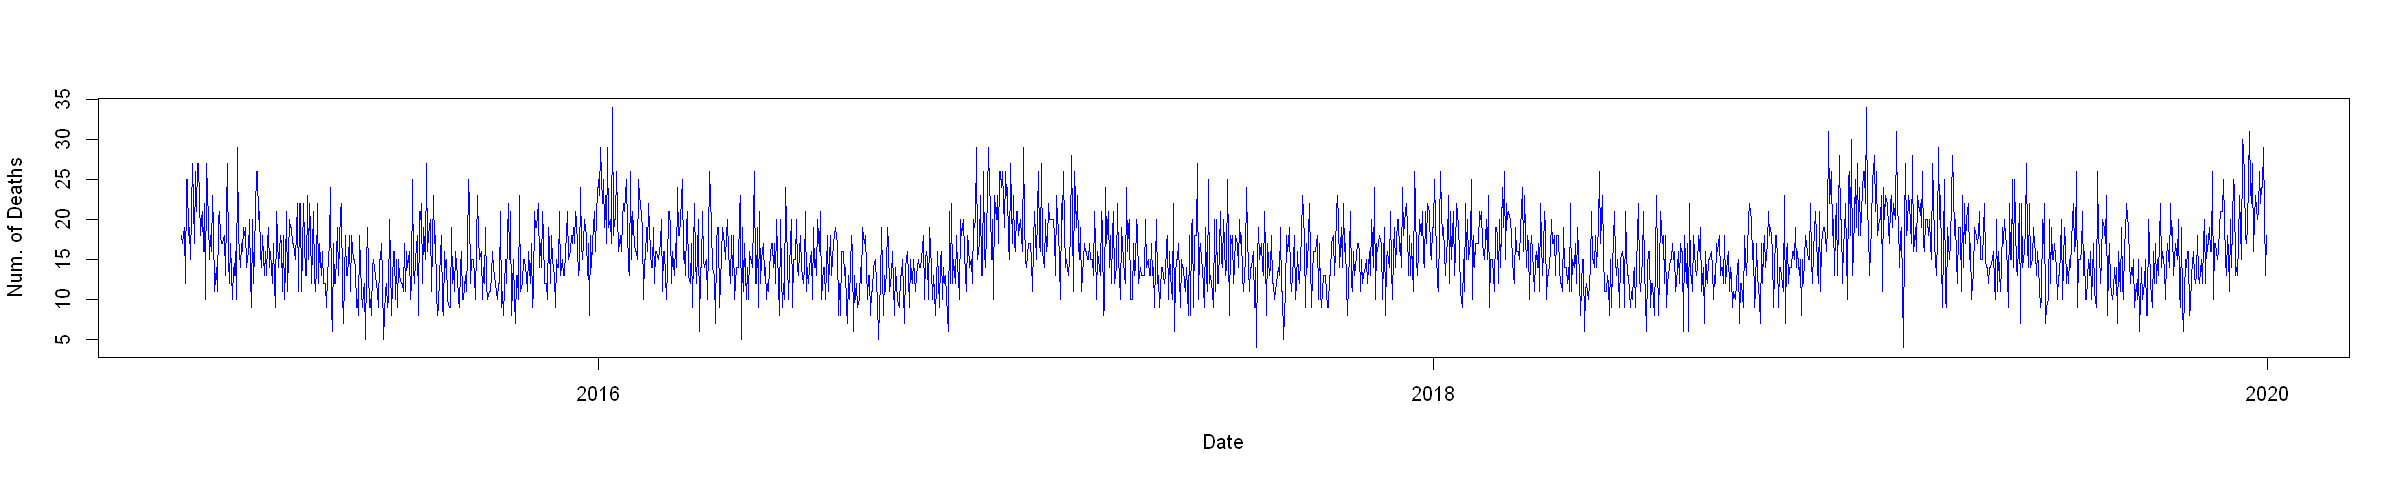

In [4]:
options(repr.plot.width=20, repr.plot.height=4)
plot(data$date, data$y, type="l", col= "blue", ylab="Num. of Deaths", xlab="Date")

Now we want to define the model as follows:
- Two spline terms for temperature, hot and cold
- Spline for trend to detrend the data and control for long-term trend and seasonality
- Day of week as a factor
- Holiday as a factor

define the required terms for temperature

In [5]:
data$l01temp 	<- (data$temp + lag(data$temp,1))/2
data$l16temp 	<- (lag(data$temp,1)+lag(data$temp,2)+lag(data$temp,3)+lag(data$temp,4)+lag(data$temp,5)+lag(data$temp,6))/6
data$l01temphot  <- ((data$l01temp - median(data$l01temp,na.rm=T))*(data$l01temp >= median(data$l01temp,na.rm=T)))+median(data$l01temp,na.rm=T)
data$l16tempcold <- ((data$l16temp - median(data$l16temp,na.rm=T))*(data$l16temp <= median(data$l16temp,na.rm=T)))+median(data$l16temp,na.rm=T)

perc.hot		    <- c(75/100, 90/100)
perc.cold		    <- c(25/100)
ktemphot.lag01	<- as.vector(quantile(data$l01temphot, perc.hot, na.rm=T))
ktempcold.lag16	<- as.vector(quantile(data$l16tempcold,perc.cold,na.rm=T))

Now perform sensitivity analysis to specify the optimal degrees of freedom per year for trend spline term

In [6]:
# Custom QAIC function for quasi-Poisson
QAIC <- function(model) {
  if (family(model)$family != "quasipoisson") {
    stop("Model must be quasi-Poisson")
  }
  
  # Overdispersion parameter (phi)
  phi <- summary(model)$dispersion
  
  # Refit as Poisson to get logLik
  mod_pois <- update(model, family = poisson)
  ll <- as.numeric(logLik(mod_pois))
  
  # Number of estimated parameters
  k <- length(coef(model))
  
  # QAIC formula
  qaic <- -2 * ll / phi + 2 * k
  return(qaic)
}

results <- data.frame(df_trend = integer(),
                      coef_PM = numeric(),
                      se_PM   = numeric(),
                      perc_increase = numeric(),
                      lowerCI = numeric(),
                      upperCI = numeric(),
                      qaic = numeric(),
                      lb_pvalue = numeric(),
                      Pr_val = numeric(),
                      stringsAsFactors = FALSE)

# Number of years in your dataset
nyears <- length(unique(format(data$date, "%Y")))

# Range of df multipliers you want to test for trend
df_range <- 4:8   # e.g. 4–10 per year, adjust as needed

results <- data.frame(df_time = integer(),
                      qaic = numeric(),
                      stringsAsFactors = FALSE)

for (df in df_range) {
  mod <- glm(y ~ PM10 + ns(l01temphot, k = ktemphot.lag01) +
                   ns(l16tempcold, k = ktempcold.lag16) +
                   ns(trend, df = df * nyears) +
                   as.factor(dow) +
                   as.factor(Holiday.1),
             data = data, family = quasipoisson)
  
  coef_PM <- coef(mod)["PM10"]
  se_PM   <- sqrt(vcov(mod)["PM10", "PM10"])
  
  # % change in mortality per unit increase (adjust as needed, e.g. per 10 units)
  perc_increase <- (exp(coef_PM * 10) - 1) * 100
  lowerCI <- (exp((coef_PM - 1.96*se_PM) * 10) - 1) * 100
  upperCI <- (exp((coef_PM + 1.96*se_PM) * 10) - 1) * 100

  qaic_val <- QAIC(mod)
  lb <- Box.test(residuals(mod, type="pearson"), lag = 20, type = "Ljung-Box")
  
  results <- rbind(results,
                   data.frame(df_trend = df,
                              coef_PM = coef_PM,
                              se_PM = se_PM,
                              perc_increase = perc_increase,
                              lowerCI = lowerCI,
                              upperCI = upperCI,
                              qaic = qaic_val,
                              lb_pvalue = lb$p.value,
                              Pr_val = summary(mod)$coefficients[2, "Pr(>|t|)"]))
}

print(results)



      df_trend      coef_PM        se_PM perc_increase     lowerCI   upperCI
PM10         4 0.0002731276 0.0001579837     0.2735009 -0.03651380 0.5844770
PM101        5 0.0002380164 0.0001597962     0.2382999 -0.07515594 0.5527390
PM102        6 0.0002026582 0.0001609661     0.2028637 -0.11277183 0.5194966
PM103        7 0.0001985849 0.0001616511     0.1987822 -0.11818130 0.5167515
PM104        8 0.0002375747 0.0001621345     0.2378571 -0.08017671 0.5569032
          qaic  lb_pvalue     Pr_val
PM10  9719.265 0.43747882 0.08401499
PM101 9748.029 0.31949451 0.13653637
PM102 9751.860 0.26345015 0.20819496
PM103 9802.524 0.08982221 0.21943374
PM104 9810.940 0.05404043 0.14302218


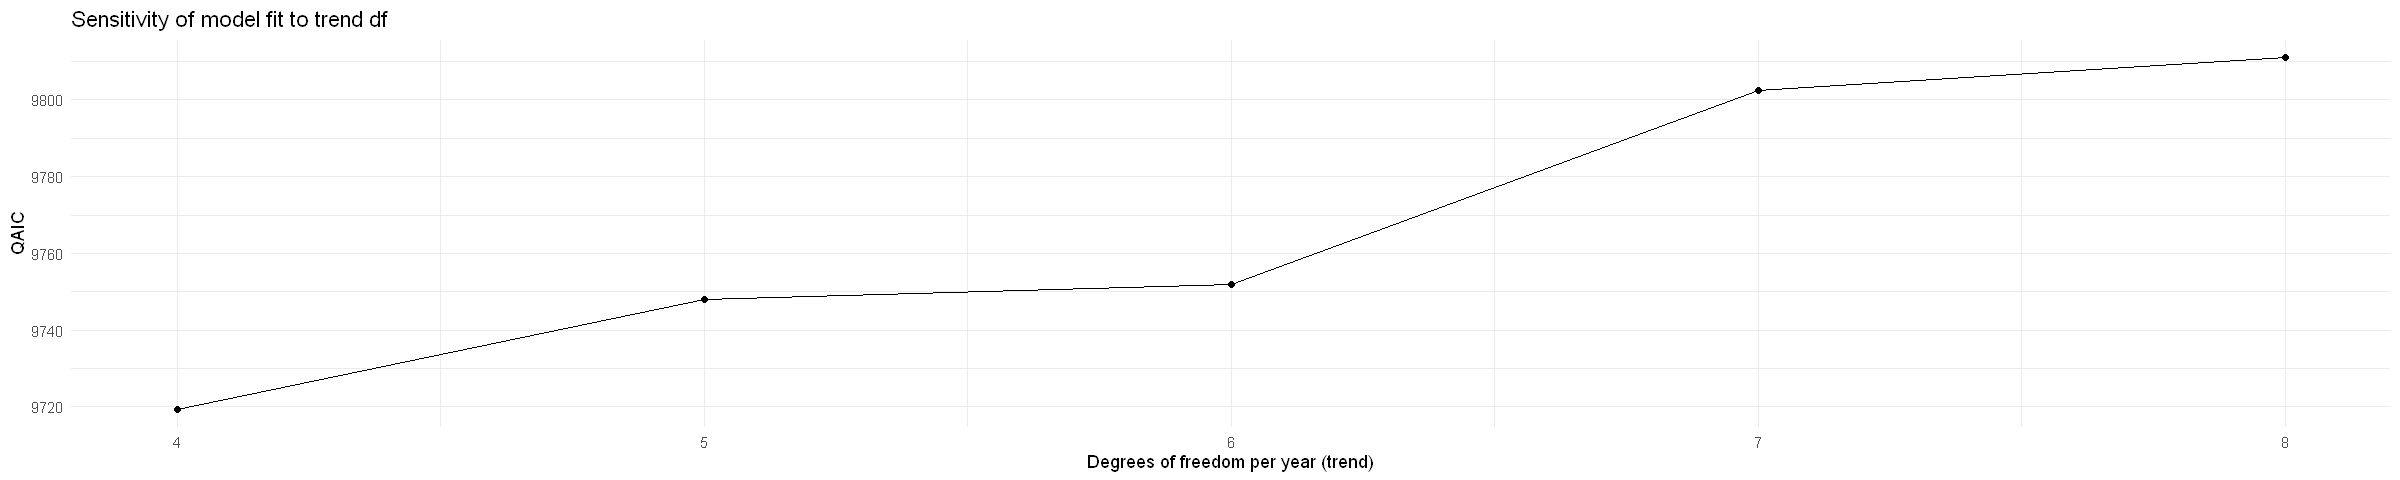

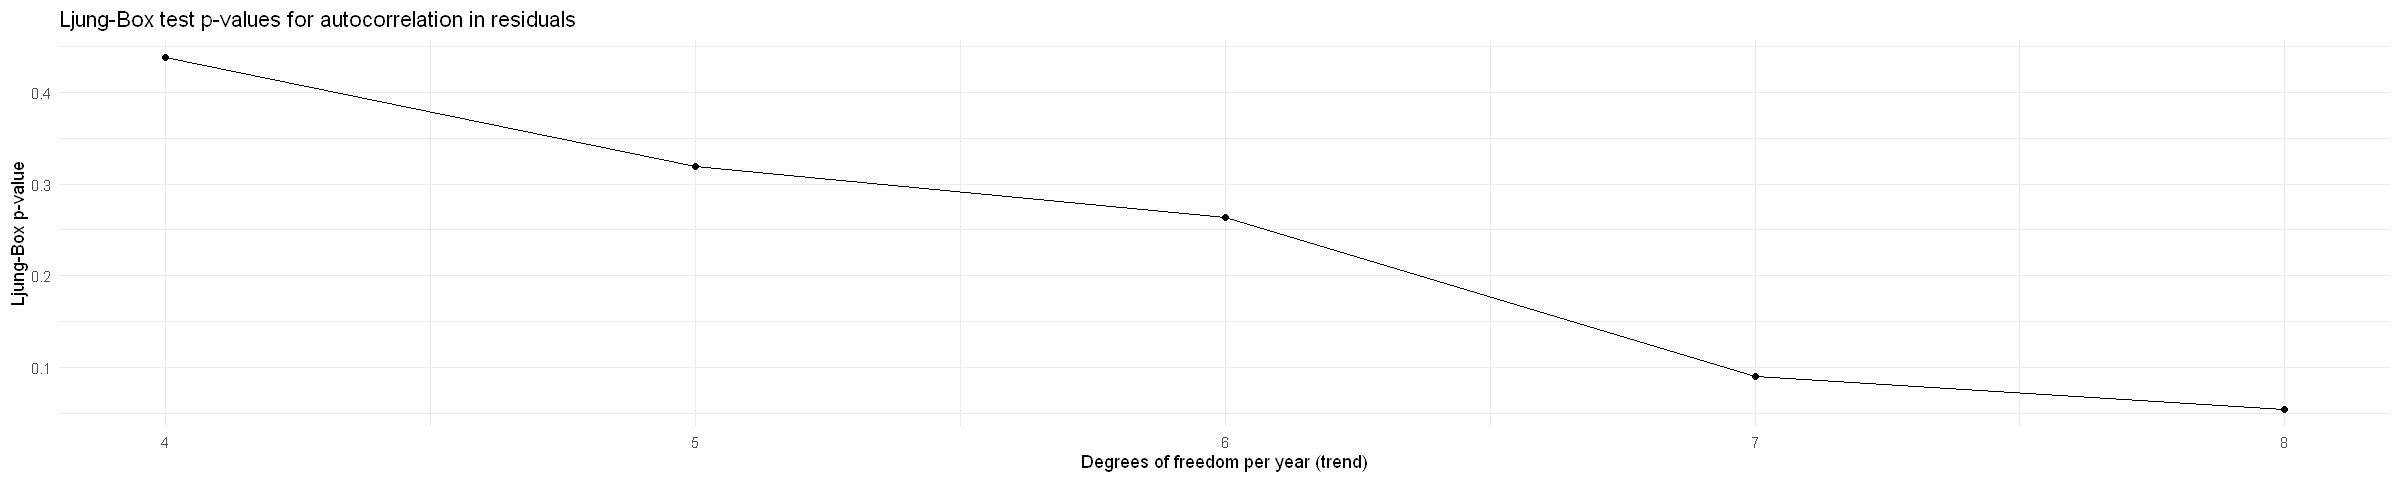

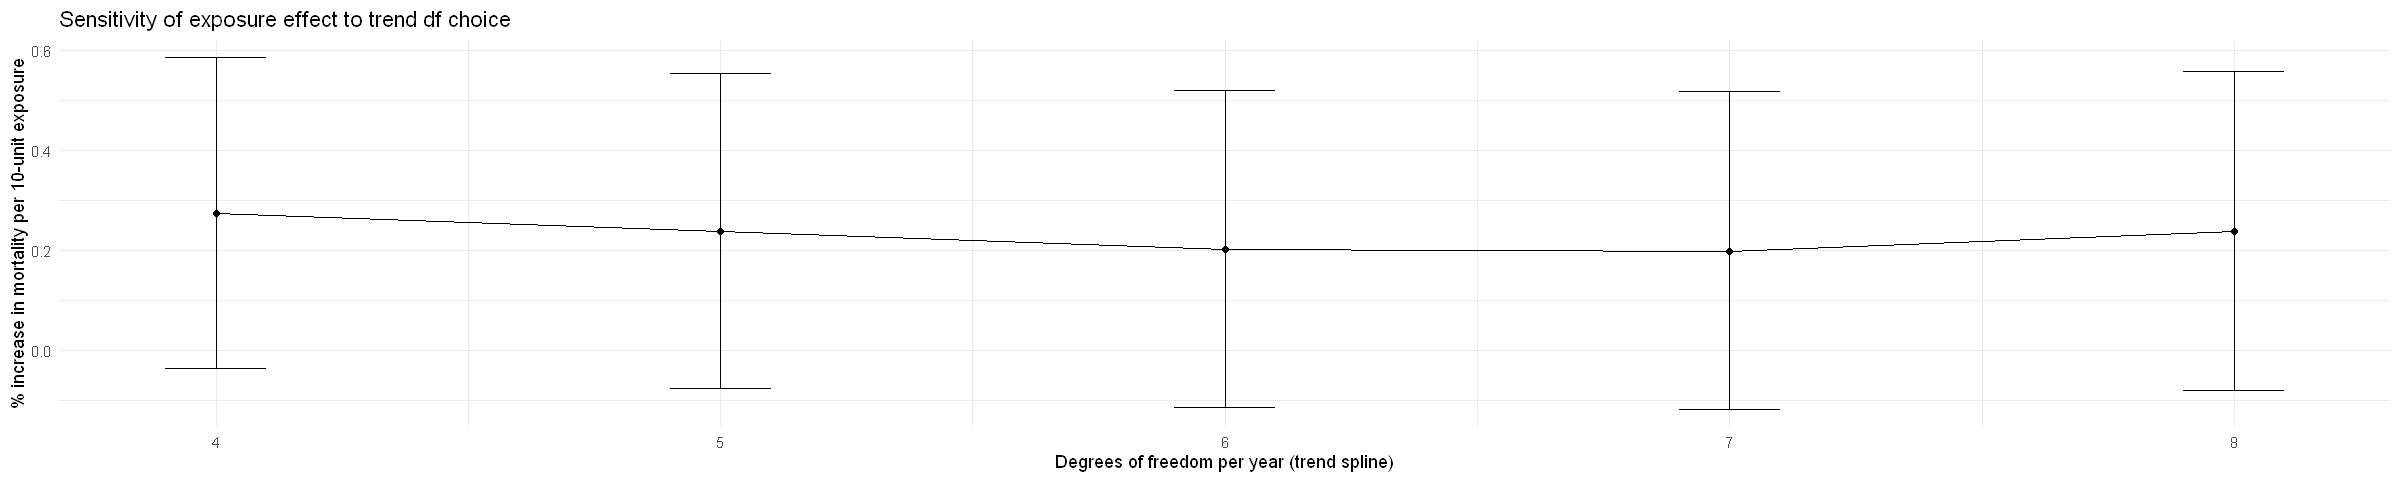

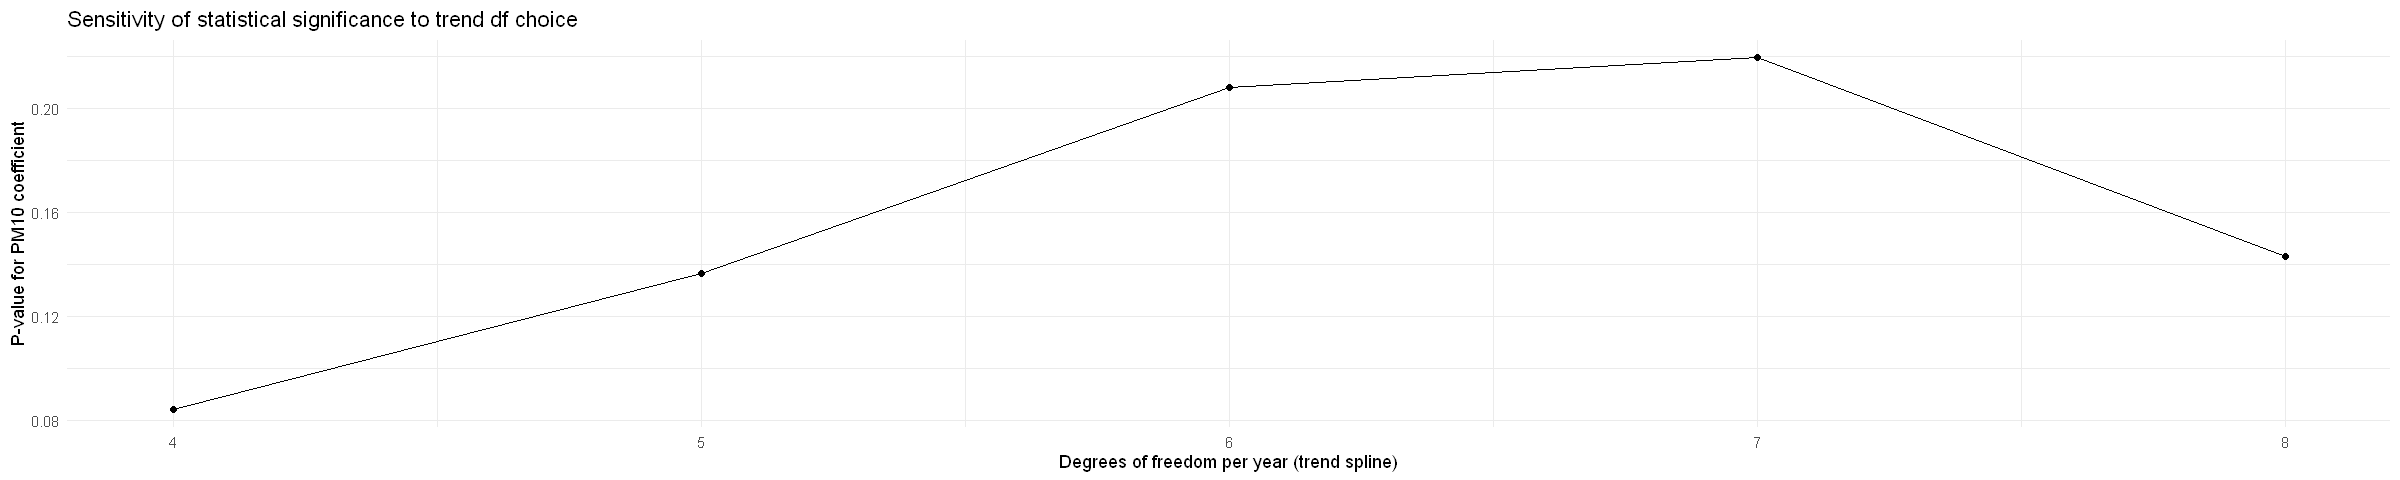

In [7]:
ggplot(results, aes(x = df_trend, y = qaic)) +
  geom_point() +
  geom_line() +
  labs(x = "Degrees of freedom per year (trend)",
       y = "QAIC",
       title = "Sensitivity of model fit to trend df") +
  theme_minimal()

ggplot(results, aes(x = df_trend, y = lb_pvalue)) +
  geom_point() +
  geom_line() +
  labs(x = "Degrees of freedom per year (trend)",
       y = "Ljung-Box p-value",
       title = "Ljung-Box test p-values for autocorrelation in residuals"
       ) +
  theme_minimal()

ggplot(results, aes(x = df_trend, y = perc_increase)) +
  geom_point() +
  geom_errorbar(aes(ymin = lowerCI, ymax = upperCI), width = 0.2) +
  geom_line() +
  labs(x = "Degrees of freedom per year (trend spline)",
       y = "% increase in mortality per 10-unit exposure",
       title = "Sensitivity of exposure effect to trend df choice") +
  theme_minimal()

ggplot(results, aes(x = df_trend, y = Pr_val)) +
  geom_point() +
  geom_line() +
  labs(x = "Degrees of freedom per year (trend spline)",
       y = "P-value for PM10 coefficient",
       title = "Sensitivity of statistical significance to trend df choice") +
  theme_minimal()

We pick 4 degrees of freedom for trend spline term

Define the model using the specified degrees of freedom

In [8]:
model5 <- glm(y ~ ns(l01temphot, k=ktemphot.lag01) + ns(l16tempcold, k=ktempcold.lag16) + ns(trend, df=4*nyears) + as.factor(dow) + as.factor(Holiday.1), data=data, family=quasipoisson)

Now we analyze single lags

In [9]:
data <- arrange(data, date) %>% mutate( PM10_l1=lag(PM10,1), PM10_l2=lag(PM10,2), PM10_l3=lag(PM10,3),
                                        PM10_l4=lag(PM10,4), PM10_l5=lag(PM10,5), PM10_l6=lag(PM10,6), PM10_l7=lag(PM10,7))

In [10]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])

res1       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6)   
res1[, RR    := exp(beta*10)]
res1[, inf   := exp((beta-1.96*se)*10)]
res1[, sup   := exp((beta+1.96*se)*10)]
res1[, IR10  := (RR-1)*100]
res1[, inf10 := (inf-1)*100]
res1[, sup10 := (sup-1)*100]
res1[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res1

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,2.731276e-04,0.0001579837,0.084014991,1.0027350,0.9996349,1.005845,0.27350089,-0.0365138,0.5844770,
1,4.732333e-04,0.0001559488,0.002444443,1.0047435,1.0016771,1.007819,0.47435482,0.1677142,0.7819341,**
2,1.778721e-04,0.0001551140,0.251654690,1.0017803,0.9987393,1.004831,0.17803037,-0.1260719,0.4830586,
3,2.273735e-04,0.0001545701,0.141469217,1.0022763,0.9992444,1.005317,0.22763222,-0.0755554,0.5317398,
4,4.636311e-05,0.0001567048,0.767369991,1.0004637,0.9973956,1.003541,0.04637386,-0.2604386,0.3541301,
5,2.013030e-04,0.0001544735,0.192692706,1.0020151,0.9989859,1.005053,0.20150579,-0.1014135,0.5053436,
6,-1.274002e-04,0.0001552620,0.412014473,0.9987268,0.9956922,1.001771,-0.12731904,-0.4307831,0.1770699,


Average Lags

In [11]:
# Build the average lags
data <- arrange(data, date) %>% mutate( PM10_l01=(PM10    + PM10_l1)/2,
                                        PM10_l25=(PM10_l2 + PM10_l3 + PM10_l4 + PM10_l5)/4,
                                        PM10_l05=(PM10    + PM10_l1 + PM10_l2 + PM10_l3 + PM10_l4 + PM10_l5)/6)

In [12]:
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res       <- rbind(cp_mod5_01, cp_mod5_25, cp_mod5_05)   
res[, RR    := exp(beta*10)]
res[, inf   := exp((beta-1.96*se)*10)]
res[, sup   := exp((beta+1.96*se)*10)]
res[, IR10  := (RR-1)*100]
res[, inf10 := (inf-1)*100]
res[, sup10 := (sup-1)*100]
res[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
01,0.0005881129,0.0001863957,0.001631387,1.005898,1.002230,1.009580,0.5898457,0.223025629,0.9580083,**
25,0.0004775276,0.0002429176,0.049482161,1.004787,1.000014,1.009582,0.4786696,0.001409169,0.9582077,*
05,0.0009754027,0.0002959443,0.001001211,1.009802,1.003961,1.015676,0.9801753,0.396134521,1.5676136,**


Now check for NO2

In [13]:
data <- arrange(data, date) %>% mutate( NO2_l1=lag(NO2,1), NO2_l2=lag(NO2,2), NO2_l3=lag(NO2,3),
                                        NO2_l4=lag(NO2,4), NO2_l5=lag(NO2,5), NO2_l6=lag(NO2,6), NO2_l7=lag(NO2,7))

data <- arrange(data, date) %>% mutate( NO2_l01=(NO2    + NO2_l1)/2,
                                        NO2_l25=(NO2_l2 + NO2_l3 + NO2_l4 + NO2_l5)/4,
                                        NO2_l05=(NO2    + NO2_l1 + NO2_l2 + NO2_l3 + NO2_l4 + NO2_l5)/6)

In [14]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0005774826,0.001085645,0.5948447,1.0057915,0.9846158,1.027423,0.5791532,-1.538425,2.7422734,
1,-0.0007740648,0.001114105,0.4872815,0.9922892,0.9708560,1.014196,-0.7710766,-2.914399,1.4195634,
2,-0.0004470682,0.001104537,0.6857060,0.9955393,0.9742186,1.017327,-0.4460703,-2.578143,1.7326629,
3,-0.0001384457,0.001101405,0.8999844,0.9986165,0.9772899,1.020409,-0.1383499,-2.271014,2.0408535,
4,-0.0015023930,0.001114556,0.1778406,0.9850884,0.9638022,1.006845,-1.4911634,-3.619783,0.6844681,
5,0.0004539121,0.001132362,0.6885762,1.0045494,0.9824998,1.027094,0.4549439,-1.750023,2.7093957,
6,0.0004780939,0.001144319,0.6761461,1.0047924,0.9825071,1.027583,0.4792386,-1.749290,2.7583151,
01,-0.0001618583,0.001237768,0.8959753,0.9983827,0.9744532,1.022900,-0.1617274,-2.554684,2.2899931,
25,-0.0003977193,0.001540504,0.7963028,0.9960307,0.9664062,1.026563,-0.3969294,-3.359383,2.6563360,


Now SO2

In [15]:
data <- arrange(data, date) %>% mutate( SO2_l1=lag(SO2,1), SO2_l2=lag(SO2,2), SO2_l3=lag(SO2,3),
                                        SO2_l4=lag(SO2,4), SO2_l5=lag(SO2,5), SO2_l6=lag(SO2,6), SO2_l7=lag(SO2,7))

data <- arrange(data, date) %>% mutate( SO2_l01=(SO2    + SO2_l1)/2,
                                        SO2_l25=(SO2_l2 + SO2_l3 + SO2_l4 + SO2_l5)/4,
                                        SO2_l05=(SO2    + SO2_l1 + SO2_l2 + SO2_l3 + SO2_l4 + SO2_l5)/6)

In [16]:
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0011066677,0.001054164,0.2939520,1.0111281,0.9904509,1.032237,1.1128139,-0.9549057,3.223700,
1,0.0008330315,0.001062312,0.4330472,1.0083651,0.9875867,1.029581,0.8365108,-1.2413313,2.958070,
2,-0.0004807265,0.001077808,0.6556362,0.9952043,0.9744010,1.016452,-0.4795729,-2.5598955,1.645164,
3,-0.0001648955,0.001085469,0.8792740,0.9983524,0.9773366,1.019820,-0.1647597,-2.2663389,1.982010,
4,-0.0017511913,0.001116789,0.1170478,0.9826405,0.9613651,1.004387,-1.7359471,-3.8634859,0.438675,
5,0.0002379710,0.001115353,0.8310715,1.0023825,0.9807073,1.024537,0.2382544,-1.9292678,2.453682,
6,-0.0003357450,0.001123348,0.7650678,0.9966482,0.9749442,1.018835,-0.3351820,-2.5055821,1.883535,
01,0.0011473056,0.001189790,0.3350329,1.0115391,0.9882231,1.035405,1.1539124,-1.1776923,3.540529,
25,-0.0007501816,0.001463687,0.6083468,0.9925263,0.9644569,1.021412,-0.7473747,-3.5543054,2.141248,


### Now gender based analysis

#### PM10

Male

In [17]:
data$y <- data$Total_Male..30

In [18]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res4       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res4[, RR    := exp(beta*10)]
res4[, inf   := exp((beta-1.96*se)*10)]
res4[, sup   := exp((beta+1.96*se)*10)]
res4[, IR10  := (RR-1)*100]
res4[, inf10 := (inf-1)*100]
res4[, sup10 := (sup-1)*100]
res4[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res4

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0003732165,0.0002060865,0.070316621,1.0037391,0.9996929,1.007802,0.37391385,-0.03070824,0.7801736,
1,0.0005733538,0.0002039992,0.005000387,1.0057500,1.0017367,1.009779,0.57500066,0.17366610,0.9779431,**
2,0.0002097441,0.0002036563,0.303202660,1.0020996,0.9981076,1.006108,0.20996418,-0.18924296,0.6107680,
3,0.0002948118,0.0002017731,0.144165844,1.0029525,0.9989939,1.006927,0.29524681,-0.10061289,0.6926751,
4,0.0000973711,0.0002053712,0.635471718,1.0009742,0.9969531,1.005012,0.09741852,-0.30469138,0.5011503,
5,0.0002551408,0.0002024483,0.207737531,1.0025547,0.9985844,1.006541,0.25546657,-0.14155759,0.6540692,
6,-0.0001841878,0.0002042675,0.367340792,0.9981598,0.9941715,1.002164,-0.18401830,-0.58284703,0.2164104,
01,0.0007275982,0.0002435337,0.002850446,1.0073025,1.0025059,1.012122,0.73025161,0.25058554,1.2122127,**
25,0.0005488122,0.0003183800,0.084929941,1.0055032,0.9992482,1.011797,0.55032093,-0.07518435,1.1797417,


Female

In [19]:
data$y <- data$Total_Female..30

In [20]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res4       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res4[, RR    := exp(beta*10)]
res4[, inf   := exp((beta-1.96*se)*10)]
res4[, sup   := exp((beta+1.96*se)*10)]
res4[, IR10  := (RR-1)*100]
res4[, inf10 := (inf-1)*100]
res4[, sup10 := (sup-1)*100]
res4[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res4

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,1.380063e-04,0.0002367419,0.56000875,1.0013810,0.9967452,1.006038,0.13810159,-0.3254770,0.6038363,
1,3.370755e-04,0.0002332126,0.14853641,1.0033764,0.9988005,1.007973,0.33764425,-0.1199492,0.7973341,
2,1.363301e-04,0.0002305054,0.55430177,1.0013642,0.9968504,1.005899,0.13642312,-0.3149633,0.5898535,
3,1.380246e-04,0.0002307359,0.54978836,1.0013812,0.9968628,1.005920,0.13811991,-0.3137245,0.5920124,
4,-2.138413e-05,0.0002328563,0.92684040,0.9997862,0.9952336,1.004360,-0.02138184,-0.4766429,0.4359617,
5,1.318026e-04,0.0002293657,0.56560886,1.0013189,0.9968275,1.005831,0.13188951,-0.3172499,0.5830526,
6,-5.175398e-05,0.0002288313,0.82109831,0.9994826,0.9950099,1.003975,-0.05174059,-0.4990142,0.3975435,
01,3.995603e-04,0.0002790604,0.15237890,1.0040036,0.9985271,1.009510,0.40035956,-0.1472895,0.9510122,
25,3.851954e-04,0.0003628689,0.28859911,1.0038594,0.9967450,1.011025,0.38593824,-0.3254968,1.1024512,


#### NO2

Male

In [21]:
data$y <- data$Total_Male..30

In [22]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0011539863,0.001418547,0.4160425,1.0116067,0.9838679,1.040128,1.1606704,-1.613212,4.0127582,
1,-0.0001501951,0.001458188,0.9179738,0.9984992,0.9703655,1.027448,-0.1500824,-2.963446,2.7448485,
2,-0.0010130019,0.001448323,0.4843756,0.9899211,0.9622152,1.018425,-1.0078883,-3.778480,1.8424796,
3,-0.0011890816,0.001441384,0.4095074,0.9881796,0.9606531,1.016495,-1.1820400,-3.934692,1.6494867,
4,-0.0019747920,0.001461486,0.1767986,0.9804458,0.9527592,1.008937,-1.9554207,-4.724076,0.8936901,
5,0.0015854866,0.001475165,0.2826185,1.0159812,0.9870265,1.045785,1.5981221,-1.297348,4.5785322,
6,0.0014485530,0.001493812,0.3323286,1.0145910,0.9853157,1.044736,1.4590954,-1.468430,4.4736026,
01,0.0004853437,0.001619052,0.7643881,1.0048652,0.9734781,1.037264,0.4865234,-2.652193,3.7264393,
25,-0.0009667071,0.002018160,0.6319964,0.9903795,0.9519688,1.030340,-0.9620495,-4.803119,3.0340022,


Female

In [23]:
data$y <- data$Total_Female..30

In [24]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-0.0001797732,0.001617330,0.9115067,0.9982039,0.9670574,1.030353,-0.1796117,-3.294258,3.035349,
1,-0.0016066188,0.001656133,0.3321291,0.9840622,0.9526322,1.016529,-1.5937815,-4.736780,1.652914,
2,0.0003118488,0.001641785,0.8493742,1.0031234,0.9713577,1.035928,0.3123356,-2.864231,3.592783,
3,0.0012697739,0.001634532,0.4373565,1.0127787,0.9808467,1.045750,1.2778697,-1.915329,4.575024,
4,-0.0008696690,0.001657248,0.5998115,0.9913410,0.9596576,1.024070,-0.8658984,-4.034243,2.407050,
5,-0.0010694501,0.001688042,0.5264606,0.9893625,0.9571644,1.022644,-1.0637518,-4.283561,2.264369,
6,-0.0008103646,0.001704774,0.6345966,0.9919291,0.9593328,1.025633,-0.8070900,-4.066718,2.563294,
01,-0.0010167968,0.001839568,0.5805146,0.9898836,0.9548285,1.026226,-1.0116449,-4.517147,2.622556,
25,0.0003583096,0.002289976,0.8756819,1.0035895,0.9595408,1.049660,0.3589523,-4.045919,4.966034,


#### SO2

Male

In [25]:
data$y <- data$Total_Male..30

In [26]:
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,2.370838e-03,0.001369133,0.08351439,1.0239917,0.9968783,1.051842,2.39916620,-0.3121737,5.1842499,
1,1.644619e-03,0.001382508,0.23436823,1.0165822,0.9894055,1.044505,1.65821778,-1.0594451,4.4505284,
2,-1.695819e-05,0.001406799,0.99038354,0.9998304,0.9726385,1.027783,-0.01695676,-2.7361550,2.7782619,
3,-6.424369e-04,0.001428020,0.65285294,0.9935962,0.9661719,1.021799,-0.64037767,-3.3828149,2.1799025,
4,-1.951521e-03,0.001469259,0.18427326,0.9806740,0.9528358,1.009325,-1.93260188,-4.7164189,0.9325474,
5,1.593660e-03,0.001437353,0.26769162,1.0160643,0.9878390,1.045096,1.60642646,-1.2160971,4.5095971,
6,2.885047e-04,0.001463260,0.84372070,1.0028892,0.9745350,1.032068,0.28892125,-2.5465001,3.2068396,
01,2.464793e-03,0.001552757,0.11261122,1.0249542,0.9942306,1.056627,2.49541972,-0.5769396,5.6627207,
25,-2.495769e-04,0.001918157,0.89649233,0.9975073,0.9607014,1.035723,-0.24926570,-3.9298611,3.5723390,


Female

In [27]:
data$y <- data$Total_Female..30

In [28]:
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-0.0005862368,0.001582210,0.7110415,0.9941548,0.9637979,1.025468,-0.5845218,-3.620212,2.546785,
1,-0.0002567858,0.001590073,0.8717237,0.9974354,0.9668293,1.029010,-0.2564564,-3.317067,2.901041,
2,-0.0011095595,0.001611816,0.4912976,0.9889657,0.9582111,1.020707,-1.1034266,-4.178892,2.070748,
3,0.0004661466,0.001600254,0.7708599,1.0046723,0.9736499,1.036683,0.4672348,-2.635013,3.668327,
4,-0.0014801767,0.001654107,0.3709903,0.9853072,0.9538754,1.017775,-1.4692759,-4.612463,1.777485,
5,-0.0016184821,0.001685336,0.3370206,0.9839454,0.9519741,1.016990,-1.6054551,-4.802586,1.699049,
6,-0.0011669852,0.001678034,0.4868667,0.9883980,0.9564189,1.021446,-1.1602024,-4.358113,2.144634,
01,-0.0005990287,0.001773181,0.7355340,0.9940276,0.9600743,1.029182,-0.5972381,-3.992572,2.918173,
25,-0.0014081758,0.002175276,0.5174884,0.9860169,0.9448613,1.028965,-1.3983073,-5.513872,2.896521,


### Analize by age 

#### Old

In [29]:
data$y <- data$X.65

PM10

In [30]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res4       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res4[, RR    := exp(beta*10)]
res4[, inf   := exp((beta-1.96*se)*10)]
res4[, sup   := exp((beta+1.96*se)*10)]
res4[, IR10  := (RR-1)*100]
res4[, inf10 := (inf-1)*100]
res4[, sup10 := (sup-1)*100]
res4[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res4

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0002373881,0.0001868290,0.204033760,1.0023767,0.9987129,1.006054,0.2376700,-0.12871391,0.6053981,
1,0.0005184157,0.0001838431,0.004858210,1.0051976,1.0015821,1.008826,0.5197618,0.15820829,0.8826205,**
2,0.0001598272,0.0001835964,0.384126854,1.0015996,0.9980018,1.005210,0.1599550,-0.19982172,0.5210287,
3,0.0001974794,0.0001829382,0.280519380,1.0019767,0.9983905,1.005576,0.1976745,-0.16094986,0.5575870,
4,0.0002215873,0.0001828285,0.225677530,1.0022183,0.9986334,1.005816,0.2218330,-0.13666308,0.5816161,
5,0.0002235517,0.0001824518,0.220640335,1.0022380,0.9986604,1.005828,0.2238018,-0.13396405,0.5828493,
6,-0.0001442950,0.0001831261,0.430829942,0.9985581,0.9949804,1.002149,-0.1441910,-0.50195821,0.2148627,
01,0.0005891215,0.0002196838,0.007394574,1.0059086,1.0015867,1.010249,0.5908602,0.15866699,1.0249184,**
25,0.0005421233,0.0002877949,0.059772120,1.0054360,0.9997805,1.011123,0.5435954,-0.02195228,1.1123423,


#### Young

In [31]:
data$y <- data$Total..30 - data$X.65

In [32]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res4       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res4[, RR    := exp(beta*10)]
res4[, inf   := exp((beta-1.96*se)*10)]
res4[, sup   := exp((beta+1.96*se)*10)]
res4[, IR10  := (RR-1)*100]
res4[, inf10 := (inf-1)*100]
res4[, sup10 := (sup-1)*100]
res4[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res4

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,3.463958e-04,0.0002810636,0.21794767,1.0034700,0.9979572,1.009013,0.34699646,-0.20427981,0.9013180,
1,3.751278e-04,0.0002809663,0.18200576,1.0037583,0.9982459,1.009301,0.37583226,-0.17541209,0.9301207,
2,2.126218e-04,0.0002762858,0.44165762,1.0021285,0.9967164,1.007570,0.21284800,-0.32835812,0.7569928,
3,2.862479e-04,0.0002749486,0.29797464,1.0028666,0.9974767,1.008286,0.28665801,-0.25233251,0.8285610,
4,-3.382033e-04,0.0002862382,0.23754666,0.9966237,0.9910480,1.002231,-0.33763201,-0.89519911,0.2230720,
5,1.524381e-04,0.0002768143,0.58191848,1.0015255,0.9961064,1.006974,0.15255430,-0.38935809,0.6974149,
6,-9.653617e-05,0.0002762745,0.72681513,0.9990351,0.9936400,1.004460,-0.09648959,-0.63600315,0.4459533,
01,5.838907e-04,0.0003344764,0.08104197,1.0058560,0.9992834,1.012472,0.58559870,-0.07165738,1.2471777,
25,3.358603e-04,0.0004349293,0.44009120,1.0033642,0.9948473,1.011954,0.33642497,-0.51526898,1.1954103,


NO2

Old

In [33]:
data$y <- data$X.65

In [34]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,5.763454e-04,0.001283891,0.6535555,1.0057801,0.9807862,1.031411,0.57800944,-1.921383,3.141095,
1,-7.192556e-04,0.001321031,0.5861905,0.9928332,0.9674565,1.018876,-0.71667517,-3.254345,1.887559,
2,3.063963e-04,0.001308816,0.8149332,1.0030687,0.9776644,1.029133,0.30686622,-2.233561,2.913306,
3,7.103979e-04,0.001304019,0.5859771,1.0071293,0.9817145,1.033202,0.71292722,-1.828555,3.320204,
4,6.182824e-05,0.001316604,0.9625501,1.0006185,0.9751274,1.026776,0.06184736,-2.487261,2.677593,
5,2.773164e-04,0.001343524,0.8364948,1.0027770,0.9767155,1.029534,0.27770129,-2.328454,2.953396,
6,2.610228e-04,0.001354315,0.8471894,1.0026136,0.9763498,1.029584,0.26136378,-2.365019,2.958396,
01,-9.809546e-05,0.001463651,0.9465726,0.9990195,0.9707673,1.028094,-0.09804736,-2.923273,2.809401,
25,7.806396e-04,0.001830713,0.6698602,1.0078369,0.9723149,1.044657,0.78369452,-2.768512,4.465675,


Young

In [35]:
data$y <- data$Total..30 - data$X.65

In [36]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0005991841,0.001927407,0.75593206,1.0060098,0.9687145,1.0447410,0.6009828,-3.128550,4.4741016,
1,-0.0008697947,0.001980995,0.66066521,0.9913398,0.9535862,1.0305880,-0.8660229,-4.641380,3.0588046,
2,-0.0020207322,0.001962562,0.30332092,0.9799955,0.9430146,1.0184266,-2.0004522,-5.698541,1.8426597,
3,-0.0019116237,0.001955147,0.32833830,0.9810653,0.9441813,1.0193902,-1.8934680,-5.581875,1.9390247,
4,-0.0047286877,0.001986933,0.01742398,0.9538137,0.9173825,0.9916917,-4.6186269,-8.261748,-0.8308293,*
5,0.0008432360,0.002005379,0.67418111,1.0084680,0.9695986,1.0488956,0.8468013,-3.040136,4.8895582,
6,0.0009152690,0.002024849,0.65131162,1.0091947,0.9699271,1.0500520,0.9194704,-3.007289,5.0052045,
01,-0.0002688022,0.002197474,0.90265714,0.9973156,0.9552726,1.0412089,-0.2684412,-4.472739,4.1208935,
25,-0.0028428635,0.002738577,0.29937826,0.9719717,0.9211755,1.0255689,-2.8028343,-7.882454,2.5568896,


SO2

Old

In [37]:
data$y <- data$X.65
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0010839113,0.001239959,0.3821558,1.0108981,0.9866261,1.035767,1.0898069,-1.337385,3.576710,
1,0.0008562799,0.001252500,0.4942823,1.0085996,0.9841409,1.033666,0.8599565,-1.585910,3.366610,
2,0.0003309341,0.001261504,0.7930955,1.0033148,0.9788116,1.028431,0.3314822,-2.118843,2.843148,
3,0.0005407396,0.001271088,0.6705866,1.0054220,0.9806831,1.030785,0.5422042,-1.931692,3.078508,
4,-0.0007481063,0.001302442,0.5657793,0.9925469,0.9675299,1.018211,-0.7453149,-3.247008,1.821063,
5,0.0006526576,0.001305954,0.6173099,1.0065479,0.9811106,1.032645,0.6547920,-1.888943,3.264479,
6,-0.0003052564,0.001317838,0.8168491,0.9969521,0.9715309,1.023038,-0.3047910,-2.846909,2.303844,
01,0.0011515925,0.001398884,0.4104941,1.0115825,0.9842236,1.039702,1.1582488,-1.577642,3.970191,
25,0.0004298752,0.001723427,0.8030576,1.0043080,0.9709499,1.038812,0.4308005,-2.905011,3.881218,


Young

In [38]:
data$y <- data$Total..30 - data$X.65
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0011494919,0.001894525,0.54409928,1.0115612,0.9746881,1.049829,1.1561239,-2.531192,4.98293327,
1,0.0007738708,0.001912422,0.68578051,1.0077687,0.9706933,1.046260,0.7768729,-2.930673,4.62602827,
2,-0.0022978391,0.001966245,0.24270623,0.9772836,0.9403371,1.015682,-2.2716399,-5.966285,1.56817037,
3,-0.0017175016,0.001972895,0.38411966,0.9829716,0.9456869,1.021726,-1.7028366,-5.431312,2.17263821,
4,-0.0039599217,0.002046797,0.05318869,0.9611746,0.9233782,1.000518,-3.8825415,-7.662185,0.05181315,
5,-0.0006925498,0.002030982,0.73314996,0.9930984,0.9543424,1.033428,-0.6901572,-4.565758,3.34283227,
6,-0.0004425476,0.002026085,0.82712343,0.9955843,0.9568231,1.035916,-0.4415698,-4.317690,3.59157295,
01,0.0011285955,0.002139549,0.59791889,1.0113499,0.9698157,1.054663,1.1349881,-3.018427,5.46628139,
25,-0.0033602018,0.002654562,0.20574816,0.9669563,0.9179325,1.018598,-3.3043741,-8.206752,1.85982355,


### Multi-pollutant models

#### PM10

In [75]:
data$y <- data$Total..30
mod5_single_l01 <- update(model5, . ~ PM10_l01 + .)
mod5_no2_l01 <- update(model5, . ~ PM10_l01 + NO2_l01 + .)
mod5_so2_l01 <- update(model5, . ~ PM10_l05 + SO2_l05 + .)
mod5_no2_so2_l01 <- update(model5, . ~ PM10_l01 + NO2_l01 + SO2_l01 + .)

cp_mod5_single_l01 <- data.table(Lag="Single PM10", beta=mod5_single_l01$coefficients[2], se=sqrt(summary(mod5_single_l01)$cov.scaled[2,2]), P_val = summary(mod5_single_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_no2_l01 <- data.table(Lag="NO2", beta=mod5_no2_l01$coefficients[2], se=sqrt(summary(mod5_no2_l01)$cov.scaled[2,2]), P_val = summary(mod5_no2_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_so2_l01 <- data.table(Lag="SO2", beta=mod5_so2_l01$coefficients[2], se=sqrt(summary(mod5_so2_l01)$cov.scaled[2,2]), P_val = summary(mod5_so2_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_no2_so2_l01 <- data.table(Lag="NO2+SO2", beta=mod5_no2_so2_l01$coefficients[2], se=sqrt(summary(mod5_no2_so2_l01)$cov.scaled[2,2]), P_val = summary(mod5_no2_so2_l01)$coefficients[2, "Pr(>|t|)"])

res5       <- rbind(cp_mod5_single_l01, cp_mod5_no2_l01, cp_mod5_so2_l01, cp_mod5_no2_so2_l01)
res5[, RR    := exp(beta*10)]
res5[, inf   := exp((beta-1.96*se)*10)]
res5[, sup   := exp((beta+1.96*se)*10)]
res5[, IR10  := (RR-1)*100]
res5[, inf10 := (inf-1)*100]
res5[, sup10 := (sup-1)*100]
res5[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res5

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Single PM10,0.0005881129,0.0001863957,0.0016313868,1.005898,1.002230,1.009580,0.5898457,0.2230256,0.9580083,**
NO2,0.0006235814,0.0001938362,0.0013190509,1.006255,1.002440,1.010086,0.6255297,0.2439595,1.0085523,**
SO2,0.0011867359,0.0003282673,0.0003090007,1.011938,1.005448,1.018470,1.1938056,0.5448107,1.8469896,***
NO2+SO2,0.0006014650,0.0002048155,0.0033619119,1.006033,1.002002,1.010079,0.6032775,0.2002268,1.0079494,**


#### NO2

In [76]:
data$y <- data$Total..30
mod5_single_l01 <- update(model5, . ~ NO2_l01 + .)
mod5_pm10_l01 <- update(model5, . ~ NO2_l01 + PM10_l01 + .)
mod5_so2_l01 <- update(model5, . ~ NO2_l01 + SO2_l01 + .)
mod5_pm10_so2_l01 <- update(model5, . ~ NO2_l01 + PM10_l01 + SO2_l01 + .)

cp_mod5_single_l01 <- data.table(Lag="Single NO2", beta=mod5_single_l01$coefficients[2], se=sqrt(summary(mod5_single_l01)$cov.scaled[2,2]), P_val = summary(mod5_single_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_pm10_l01 <- data.table(Lag="PM10", beta=mod5_pm10_l01$coefficients[2], se=sqrt(summary(mod5_pm10_l01)$cov.scaled[2,2]), P_val = summary(mod5_pm10_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_so2_l01 <- data.table(Lag="SO2", beta=mod5_so2_l01$coefficients[2], se=sqrt(summary(mod5_so2_l01)$cov.scaled[2,2]), P_val = summary(mod5_so2_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_pm10_so2_l01 <- data.table(Lag="PM10+SO2", beta=mod5_pm10_so2_l01$coefficients[2], se=sqrt(summary(mod5_pm10_so2_l01)$cov.scaled[2,2]), P_val = summary(mod5_pm10_so2_l01)$coefficients[2, "Pr(>|t|)"])

res6       <- rbind(cp_mod5_single_l01 ,cp_mod5_pm10_l01, cp_mod5_so2_l01, cp_mod5_pm10_so2_l01)
res6[, RR    := exp(beta*10)]
res6[, inf   := exp((beta-1.96*se)*10)]
res6[, sup   := exp((beta+1.96*se)*10)]
res6[, IR10  := (RR-1)*100]
res6[, inf10 := (inf-1)*100]
res6[, sup10 := (sup-1)*100]
res6[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res6

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Single NO2,-0.0001618583,0.001237768,0.8959753,0.9983827,0.9744532,1.022900,-0.1617274,-2.554684,2.289993,
PM10,-0.0013512887,0.001285825,0.2934454,0.9865780,0.9620248,1.011758,-1.3421997,-3.797520,1.175786,
SO2,-0.0016058039,0.001622010,0.3223075,0.9840702,0.9532773,1.015858,-1.5929796,-4.672270,1.585778,
PM10+SO2,-0.0016847062,0.001621386,0.2989251,0.9832941,0.9525371,1.015044,-1.6705944,-4.746291,1.504415,


#### SO2

In [77]:
data$y <- data$Total..30
mod5_single_l01 <- update(model5, . ~ SO2_l01 + .)
mod5_pm10_l01 <- update(model5, . ~ SO2_l01 + PM10_l01 + .)
mod5_no2_l01 <- update(model5, . ~ SO2_l01 + NO2_l01 + .)
mod5_pm10_no2_l01 <- update(model5, . ~ SO2_l01 + PM10_l01 + NO2_l01 + .)

cp_mod5_single_l01 <- data.table(Lag="Single SO2", beta=mod5_single_l01$coefficients[2], se=sqrt(summary(mod5_single_l01)$cov.scaled[2,2]), P_val = summary(mod5_single_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_pm10_l01 <- data.table(Lag="PM10", beta=mod5_pm10_l01$coefficients[2], se=sqrt(summary(mod5_pm10_l01)$cov.scaled[2,2]), P_val = summary(mod5_pm10_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_no2_l01 <- data.table(Lag="NO2", beta=mod5_no2_l01$coefficients[2], se=sqrt(summary(mod5_no2_l01)$cov.scaled[2,2]), P_val = summary(mod5_no2_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_pm10_no2_l01 <- data.table(Lag="PM10+NO2", beta=mod5_pm10_no2_l01$coefficients[2], se=sqrt(summary(mod5_pm10_no2_l01)$cov.scaled[2,2]), P_val = summary(mod5_pm10_no2_l01)$coefficients[2, "Pr(>|t|)"])

res7       <- rbind(cp_mod5_single_l01, cp_mod5_pm10_l01, cp_mod5_no2_l01, cp_mod5_pm10_no2_l01)
res7[, RR    := exp(beta*10)]
res7[, inf   := exp((beta-1.96*se)*10)]
res7[, sup   := exp((beta+1.96*se)*10)]
res7[, IR10  := (RR-1)*100]
res7[, inf10 := (inf-1)*100]
res7[, sup10 := (sup-1)*100]
res7[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res7

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Single SO2,0.0011473056,0.001189790,0.3350329,1.011539,0.9882231,1.035405,1.1539124,-1.1776923,3.540529,
PM10,-0.0004875830,0.001309272,0.7096349,0.995136,0.9699240,1.021003,-0.4863962,-3.0076007,2.100344,
NO2,0.0021466884,0.001556615,0.1680488,1.021699,0.9909980,1.053351,2.1698955,-0.9002009,5.335103,
PM10+NO2,0.0005559274,0.001645258,0.7354820,1.005575,0.9736652,1.038530,0.5574756,-2.6334820,3.853009,


In [78]:
al <- (rbind(res5, res6, res7))

In [80]:
al

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Single PM10,0.0005881129,0.0001863957,0.0016313868,1.0058985,1.0022303,1.009580,0.5898457,0.2230256,0.9580083,**
NO2,0.0006235814,0.0001938362,0.0013190509,1.0062553,1.0024396,1.010086,0.6255297,0.2439595,1.0085523,**
SO2,0.0011867359,0.0003282673,0.0003090007,1.0119381,1.0054481,1.018470,1.1938056,0.5448107,1.8469896,***
NO2+SO2,0.0006014650,0.0002048155,0.0033619119,1.0060328,1.0020023,1.010079,0.6032775,0.2002268,1.0079494,**
Single NO2,-0.0001618583,0.0012377677,0.8959752608,0.9983827,0.9744532,1.022900,-0.1617274,-2.5546843,2.2899931,
PM10,-0.0013512887,0.0012858245,0.2934454392,0.9865780,0.9620248,1.011758,-1.3421997,-3.7975198,1.1757860,
SO2,-0.0016058039,0.0016220104,0.3223074877,0.9840702,0.9532773,1.015858,-1.5929796,-4.6722701,1.5857785,
PM10+SO2,-0.0016847062,0.0016213862,0.2989251125,0.9832941,0.9525371,1.015044,-1.6705944,-4.7462908,1.5044148,
Single SO2,0.0011473056,0.0011897897,0.3350328916,1.0115391,0.9882231,1.035405,1.1539124,-1.1776923,3.5405289,


In [ ]:
#write.csv(rbind(res5, res6, res7), file="./Tables and Figures/Multi pollutant models/Amman.csv")